# Stage 1 Comparison: Single-Channel vs Multi-Channel Dataset
## Justification for Multi-Channel Data Collection

Trains the same **DualCircuit_PI_HLNN** on two 600-sample datasets under **equal sample conditions**:
- **Single-Channel**: channel 5 only — 100 samples per scenario
- **Multi-Channel**: 4 channels with distinct center frequencies (c1, c3, c4, c7) — **25 samples per channel per scenario**

Channels selected to maximise diversity across both center frequency and bandwidth:

| Channel | Center Freq | Bandwidth | Character |
|---|---|---|---|
| c1 | 3494.4 MHz | 499.2 MHz | Low-freq, narrowband |
| c3 | 4492.8 MHz | 499.2 MHz | Mid-freq, narrowband |
| c4 | 3993.6 MHz | 1331.2 MHz | Mid-freq, **wideband** |
| c7 | 6489.6 MHz | 1081.6 MHz | High-freq, **wideband** |

All four channels have **distinct center frequencies**, spanning 3.5–6.5 GHz with bandwidths ranging from 499 MHz to 1331 MHz.

Three levels of evaluation:
1. Single 70/15/15 split
2. Stratified 5-Fold CV (mean ± std)

In [11]:
CONFIG = {
    "pre_crop": 10, "post_crop": 50, "total_len": 60,
    "search_start": 740, "search_end": 890,
    "hidden_size": 32, "input_size": 1, "dropout": 0.2, "ode_unfolds": 6,
    "batch_size": 64, "max_epochs": 50, "lr": 1e-3,
    "weight_decay": 1e-4, "warmup_epochs": 3, "patience": 40,
    "grad_clip": 1.0, "val_ratio": 0.15, "test_ratio": 0.15, "seed": 42,
}
DATA_DIR = "../dataset/channels/"

In [12]:
import copy, math, contextlib, io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

Device: cuda


---
## Section 1: Data Loading & Preprocessing

In [13]:
def get_roi_alignment(sig,
                      search_start=CONFIG['search_start'],
                      search_end=CONFIG['search_end']):
    region = sig[search_start:search_end]
    if len(region) == 0:
        return np.argmax(sig)
    peak_idx = search_start + np.argmax(region)
    peak_val = sig[peak_idx]
    noise_section = sig[:search_start]
    if len(noise_section) > 10:
        threshold = max(np.mean(noise_section) + 3*np.std(noise_section), 0.05*peak_val)
    else:
        threshold = 0.05 * peak_val
    leading_edge = peak_idx
    for i in range(peak_idx, max(search_start - 20, 0), -1):
        if sig[i] < threshold:
            leading_edge = i + 1
            break
    return leading_edge


def _process_rows(df):
    """Shared CIR + FP_AMPL preprocessing."""
    PRE = CONFIG['pre_crop']; TOTAL = CONFIG['total_len']
    cir_cols = sorted([c for c in df.columns if c.startswith('CIR')],
                      key=lambda x: int(x.replace('CIR', '')))
    seqs, labels, fp_features = [], [], []
    for _, row in df.iterrows():
        sig = pd.to_numeric(row[cir_cols], errors='coerce').fillna(0).astype(float).values
        rxpacc = float(row.get('RXPACC', 128.0))
        if rxpacc > 0:
            sig = sig / rxpacc
        # FP_AMPL conditioning features
        f1 = float(row.get('FP_AMPL1', 0)) / max(rxpacc, 1) / 64.0
        f2 = float(row.get('FP_AMPL2', 0)) / max(rxpacc, 1) / 64.0
        f3 = float(row.get('FP_AMPL3', 0)) / max(rxpacc, 1) / 64.0
        fp_features.append([f1, f2, f3])
        le = get_roi_alignment(sig)
        start = max(0, le - PRE); end = start + TOTAL
        if end > len(sig): end = len(sig); start = max(0, end - TOTAL)
        crop = sig[start:end]
        if len(crop) < TOTAL:
            crop = np.pad(crop, (0, TOTAL - len(crop)), mode='constant')
        lo, hi = crop.min(), crop.max()
        crop = (crop - lo) / (hi - lo) if hi > lo else np.zeros(TOTAL)
        seqs.append(crop); labels.append(float(row['Label']))
    X = np.array(seqs).reshape(-1, TOTAL, 1).astype(np.float32)
    y = np.array(labels).astype(np.float32)
    F = np.array(fp_features).astype(np.float32)
    return X, y, F


def load_cir_dataset(filepath):
    print(f'Loading: {filepath}')
    df = pd.read_csv(filepath)
    print(f'  Samples: {len(df)}')
    X, y, F = _process_rows(df)
    print(f'  Output: X={X.shape}, y={y.shape}, F={F.shape} | LOS={int((y==0).sum())}, NLOS={int((y==1).sum())}')
    return X, y, F

print("Data loading functions ready (with FP_AMPL extraction).")

Data loading functions ready (with FP_AMPL extraction).


---
## Section 2: DualCircuit_PI_HLNN Architecture
Identical to Stage 1 main notebook — includes FP_AMPL conditioning, tau tracking, and state clamping.

In [14]:
class PILiquidCell(nn.Module):
    def __init__(self, input_size, hidden_size, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.ode_unfolds = ode_unfolds
        self.gleak = nn.Parameter(torch.empty(hidden_size).uniform_(0.001, 1.0))
        self.vleak = nn.Parameter(torch.empty(hidden_size).uniform_(-0.2, 0.2))
        self.cm    = nn.Parameter(torch.empty(hidden_size).uniform_(0.4, 0.6))
        self.w     = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.001, 1.0))
        self.erev  = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(-0.2, 0.2))
        self.mu    = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(0.3, 0.8))
        self.sigma = nn.Parameter(torch.empty(hidden_size, hidden_size).uniform_(3, 8))
        self.sensory_w     = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.001, 1.0))
        self.sensory_mu    = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(0.3, 0.8))
        self.sensory_sigma = nn.Parameter(torch.empty(input_size, hidden_size).uniform_(3, 8))

    def forward(self, x_t, h_prev, dt=1.0):
        gleak     = F.softplus(self.gleak)
        cm        = F.softplus(self.cm)
        w         = F.softplus(self.w)
        sensory_w = F.softplus(self.sensory_w)
        sensory_gate    = torch.sigmoid(self.sensory_sigma * (x_t.unsqueeze(-1) - self.sensory_mu))
        sensory_current = (sensory_w * sensory_gate * x_t.unsqueeze(-1)).sum(dim=1)
        cm_t = cm / (dt / self.ode_unfolds)
        v = h_prev
        for _ in range(self.ode_unfolds):
            rg = torch.sigmoid(self.sigma.unsqueeze(0) * (v.unsqueeze(2) - self.mu.unsqueeze(0)))
            wg = w.unsqueeze(0) * rg
            w_num = (wg * self.erev.unsqueeze(0)).sum(dim=1)
            w_den = wg.sum(dim=1)
            v = (cm_t*v + gleak*self.vleak + w_num + sensory_current) / (cm_t + gleak + w_den + 1e-8)
            v = torch.clamp(v, -1.0, 1.0)
        return v, cm / (gleak + w_den + 1e-8)


class DualCircuit_PI_HLNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, dropout=0.4, ode_unfolds=6):
        super().__init__()
        self.hidden_size = hidden_size
        self.cell_los  = PILiquidCell(input_size, hidden_size, ode_unfolds)
        self.cell_nlos = PILiquidCell(input_size, hidden_size, ode_unfolds)
        # FP_AMPL conditioning
        self.fp_to_los_init  = nn.Linear(3, hidden_size)
        self.fp_to_nlos_init = nn.Linear(3, hidden_size)
        # Cross-circuit projections
        self.P_nlos2los = nn.Linear(hidden_size, hidden_size, bias=False)
        self.P_los2nlos = nn.Linear(hidden_size, hidden_size, bias=False)
        self.gate_los   = nn.Linear(hidden_size * 2, hidden_size)
        self.gate_nlos  = nn.Linear(hidden_size * 2, hidden_size)
        # Attention pooling
        self.los_attn   = nn.Linear(hidden_size, 1)
        self.nlos_attn  = nn.Linear(hidden_size, 1)
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size*2, hidden_size), nn.SiLU(),
            nn.Dropout(dropout), nn.Linear(hidden_size, 1), nn.Sigmoid()
        )

    def _run_circuits(self, x_seq, fp_features=None):
        batch_size, seq_len, _ = x_seq.size()
        if fp_features is not None:
            h_los  = 0.1 * torch.tanh(self.fp_to_los_init(fp_features))
            h_nlos = 0.1 * torch.tanh(self.fp_to_nlos_init(fp_features))
        else:
            h_los  = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
            h_nlos = torch.zeros(batch_size, self.hidden_size, device=x_seq.device)
        los_states, nlos_states = [], []
        tau_los_sum  = torch.zeros_like(h_los)
        tau_nlos_sum = torch.zeros_like(h_nlos)
        tau_los_hist_list, tau_nlos_hist_list = [], []
        for t in range(seq_len):
            x_t = x_seq[:, t, :]
            p_n2l = self.P_nlos2los(h_nlos); p_l2n = self.P_los2nlos(h_los)
            gl = torch.sigmoid(self.gate_los( torch.cat([h_los,  p_n2l], dim=1)))
            gn = torch.sigmoid(self.gate_nlos(torch.cat([h_nlos, p_l2n], dim=1)))
            h_los,  tau_los  = self.cell_los( x_t, h_los  + gl * p_n2l)
            h_nlos, tau_nlos = self.cell_nlos(x_t, h_nlos + gn * p_l2n)
            los_states.append(h_los.unsqueeze(1))
            nlos_states.append(h_nlos.unsqueeze(1))
            tau_los_sum  += tau_los
            tau_nlos_sum += tau_nlos
            tau_los_hist_list.append(tau_los.unsqueeze(1))
            tau_nlos_hist_list.append(tau_nlos.unsqueeze(1))
        los_all  = torch.cat(los_states, dim=1)
        nlos_all = torch.cat(nlos_states, dim=1)
        tau_los_mean  = tau_los_sum  / seq_len
        tau_nlos_mean = tau_nlos_sum / seq_len
        tau_los_hist  = torch.cat(tau_los_hist_list, dim=1)
        tau_nlos_hist = torch.cat(tau_nlos_hist_list, dim=1)
        return los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean

    def _pool_and_fuse(self, la, na):
        lw = F.softmax(self.los_attn(la).squeeze(-1),  dim=1).unsqueeze(-1)
        nw = F.softmax(self.nlos_attn(na).squeeze(-1), dim=1).unsqueeze(-1)
        return torch.cat([(la*lw).sum(1), (na*nw).sum(1)], dim=1)

    def forward(self, x_seq, fp_features=None, return_dynamics=False):
        los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean = \
            self._run_circuits(x_seq, fp_features=fp_features)
        pred = self.classifier(self._pool_and_fuse(los_all, nlos_all))
        if return_dynamics:
            return pred, los_all, nlos_all, tau_los_hist, tau_nlos_hist, tau_los_mean, tau_nlos_mean
        return pred, tau_los_mean, tau_nlos_mean

    def embed(self, x_seq, fp_features=None):
        los_all, nlos_all, _, _, _, _ = self._run_circuits(x_seq, fp_features=fp_features)
        return self._pool_and_fuse(los_all, nlos_all)

_m = DualCircuit_PI_HLNN()
print(f'DualCircuit_PI_HLNN | params: {sum(p.numel() for p in _m.parameters()):,} | embed_dim=64')
print(f'  FP_AMPL conditioning: Linear(3->{_m.hidden_size}) x 2 circuits')
del _m

DualCircuit_PI_HLNN | params: 17,219 | embed_dim=64
  FP_AMPL conditioning: Linear(3->32) x 2 circuits


---
## Section 3: Training Function
With FP_AMPL conditioning, early stopping (patience=10), and best-model restoration.

In [15]:
def train_model(X_train, y_train, X_val, y_val, F_train=None, F_val=None,
                config=CONFIG, verbose=True, seed=None):
    _seed = seed if seed is not None else config['seed']
    torch.manual_seed(_seed)
    np.random.seed(_seed)
    fp_enabled = F_train is not None

    X_tr = torch.tensor(X_train).to(device)
    y_tr = torch.tensor(y_train).unsqueeze(1).to(device)
    X_va = torch.tensor(X_val).to(device)
    y_va = torch.tensor(y_val).unsqueeze(1).to(device)

    if fp_enabled:
        F_tr = torch.tensor(F_train).to(device)
        F_va = torch.tensor(F_val).to(device)
        loader = DataLoader(TensorDataset(X_tr, y_tr, F_tr),
                            batch_size=config['batch_size'], shuffle=True)
    else:
        loader = DataLoader(TensorDataset(X_tr, y_tr),
                            batch_size=config['batch_size'], shuffle=True)

    model = DualCircuit_PI_HLNN(
        input_size=config['input_size'], hidden_size=config['hidden_size'],
        dropout=config['dropout'], ode_unfolds=config['ode_unfolds']
    ).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['lr'],
                            weight_decay=config['weight_decay'])
    T = config['max_epochs']; W = config['warmup_epochs']
    def lr_lambda(e):
        if e < W: return (e+1)/W
        return max(0.01, 0.5*(1+math.cos(math.pi*(e-W)/max(1,T-W))))
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    best_val_acc = 0; best_state = None; patience_counter = 0

    for epoch in range(T):
        model.train(); tl, tc, tt = 0, 0, 0
        for batch in loader:
            if fp_enabled:
                bx, by, bf = batch
            else:
                bx, by = batch; bf = None
            optimizer.zero_grad()
            pred, _, _ = model(bx, fp_features=bf)
            loss = criterion(pred, by); loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
            optimizer.step()
            tl += loss.item()*len(bx); tc += ((pred>0.5).float()==by).sum().item(); tt += len(bx)
        model.eval()
        with torch.no_grad():
            val_fp = F_va if fp_enabled else None
            vp, _, _ = model(X_va, fp_features=val_fp)
            vl = criterion(vp, y_va).item()
            va = ((vp>0.5).float()==y_va).float().mean().item()
        history['train_loss'].append(tl/tt); history['val_loss'].append(vl)
        history['train_acc'].append(tc/tt);  history['val_acc'].append(va)
        scheduler.step()

        if va > best_val_acc:
            best_val_acc = va; best_state = copy.deepcopy(model.state_dict()); patience_counter = 0
        else:
            patience_counter += 1

        if verbose and (epoch%10==0 or epoch==T-1):
            print(f'  Ep {epoch:>3} | Loss: {tl/tt:.4f} | Val Acc: {100*va:.2f}% | Best: {100*best_val_acc:.2f}%')
        if patience_counter >= config.get('patience', T):
            if verbose: print(f'  Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_state)
    if verbose: print(f'  Best Val Acc: {100*best_val_acc:.2f}%')
    return model, history

print('train_model() ready — 40 epochs max, early stopping with patience=10, FP_AMPL support.')

train_model() ready — 40 epochs max, early stopping with patience=10, FP_AMPL support.


In [16]:
def evaluate(model, X, y_true, F=None):
    """Returns metrics dict for a given model and data."""
    model.eval()
    X_t = torch.tensor(X).to(device)
    F_t = torch.tensor(F).to(device) if F is not None else None
    with torch.no_grad():
        pred, _, _ = model(X_t, fp_features=F_t)
    y_prob = pred.cpu().numpy().flatten()
    y_pred = (y_prob > 0.5).astype(float)
    y_true = y_true.flatten()
    rep  = classification_report(y_true, y_pred, target_names=['LOS','NLOS'],
                                 output_dict=True, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return {
        'acc':      rep['accuracy'],
        'f1_macro': rep['macro avg']['f1-score'],
        'f1_los':   rep['LOS']['f1-score'],
        'f1_nlos':  rep['NLOS']['f1-score'],
        'auc':      auc(fpr, tpr),
        'fpr': fpr, 'tpr': tpr,
        'cm':  confusion_matrix(y_true, y_pred),
    }

print('evaluate() helper ready (with FP_AMPL support).')

evaluate() helper ready (with FP_AMPL support).


---
## Section 4: Single 70/15/15 Split Comparison
Quick baseline comparison using one fixed split.

In [17]:
def run_experiment(csv_name, label, config=CONFIG, seed=42):
    print(f"\n{'='*60}\nExperiment: {label}\n{'='*60}")
    X_all, y_all, F_all = load_cir_dataset(DATA_DIR + csv_name)
    X_tr, X_tmp, y_tr, y_tmp, F_tr, F_tmp = train_test_split(
        X_all, y_all, F_all, test_size=config['val_ratio']+config['test_ratio'],
        stratify=y_all, random_state=seed)
    X_va, X_te, y_va, y_te, F_va, F_te = train_test_split(
        X_tmp, y_tmp, F_tmp,
        test_size=config['test_ratio']/(config['val_ratio']+config['test_ratio']),
        stratify=y_tmp, random_state=seed)
    print(f'  Train={len(X_tr)}, Val={len(X_va)}, Test={len(X_te)}')
    model, history = train_model(X_tr, y_tr, X_va, y_va, F_train=F_tr, F_val=F_va, config=config)
    m = evaluate(model, X_te, y_te, F=F_te)
    m['label'] = label; m['history'] = history
    print(f"\n  Test Acc={m['acc']:.4f} | Macro F1={m['f1_macro']:.4f} | AUC={m['auc']:.4f}")
    return m


results_single = run_experiment('single_channel5_dataset.csv',  'Single-Channel (c5 only)')
results_multi  = run_experiment('multi_channel4_dataset.csv',   'Multi-Channel (c1,c3,c4,c7)')


Experiment: Single-Channel (c5 only)
Loading: ../dataset/channels/single_channel5_dataset.csv
  Samples: 600
  Output: X=(600, 60, 1), y=(600,), F=(600, 3) | LOS=300, NLOS=300
  Train=420, Val=90, Test=90
  Ep   0 | Loss: 0.6936 | Val Acc: 50.00% | Best: 50.00%
  Ep  10 | Loss: 0.6845 | Val Acc: 68.89% | Best: 70.00%
  Ep  20 | Loss: 0.6483 | Val Acc: 70.00% | Best: 73.33%
  Ep  30 | Loss: 0.6239 | Val Acc: 70.00% | Best: 73.33%
  Ep  40 | Loss: 0.6211 | Val Acc: 70.00% | Best: 73.33%
  Ep  49 | Loss: 0.6180 | Val Acc: 70.00% | Best: 73.33%
  Best Val Acc: 73.33%

  Test Acc=0.6667 | Macro F1=0.6640 | AUC=0.5674

Experiment: Multi-Channel (c1,c3,c4,c7)
Loading: ../dataset/channels/multi_channel4_dataset.csv
  Samples: 600
  Output: X=(600, 60, 1), y=(600,), F=(600, 3) | LOS=300, NLOS=300
  Train=420, Val=90, Test=90
  Ep   0 | Loss: 0.6937 | Val Acc: 50.00% | Best: 50.00%
  Ep  10 | Loss: 0.6849 | Val Acc: 73.33% | Best: 73.33%
  Ep  20 | Loss: 0.6152 | Val Acc: 62.22% | Best: 74.44%


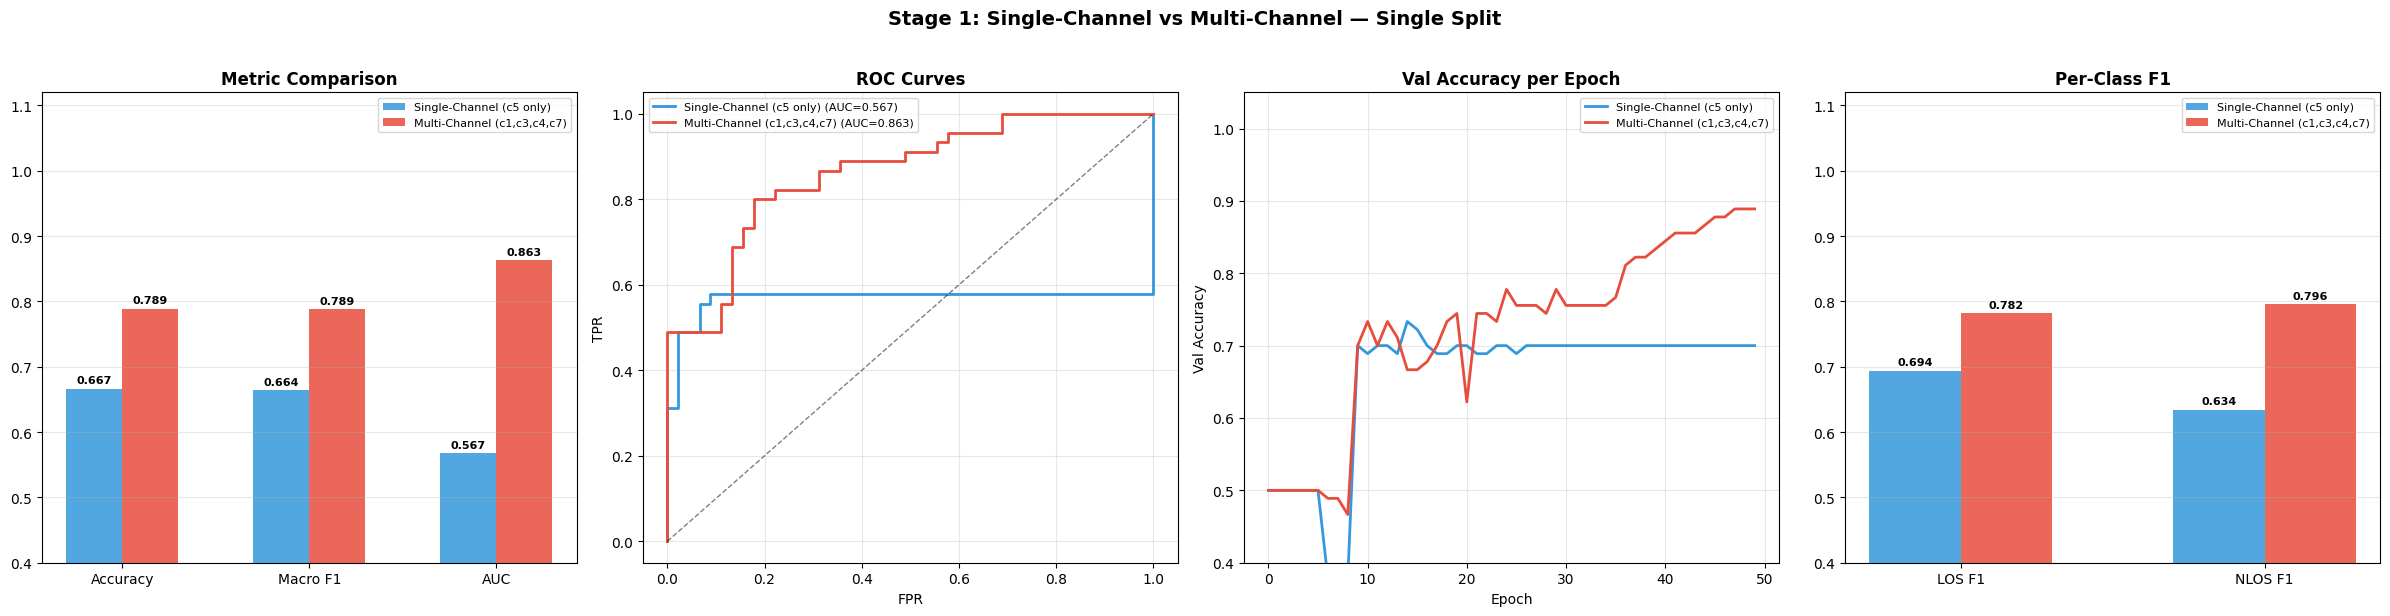


Metric                  Single-Ch     Multi-Ch  Delta
Accuracy                   0.6667       0.7889   ▲0.1222
F1 LOS                     0.6939       0.7816   ▲0.0877
F1 NLOS                    0.6341       0.7957   ▲0.1616
Macro F1                   0.6640       0.7887   ▲0.1246
AUC                        0.5674       0.8627   ▲0.2953


In [18]:
# ── Single-split plots ──────────────────────────────────────────────────
_res = [results_single, results_multi]
_colors = ['#3498db', '#e74c3c']
width = 0.3

fig, axs = plt.subplots(1, 4, figsize=(24, 6))

# Bar: key metrics
ax = axs[0]
mk = ['acc','f1_macro','auc']; mn = ['Accuracy','Macro F1','AUC']
for i, (r, c) in enumerate(zip(_res, _colors)):
    vals = [r[k] for k in mk]
    bars = ax.bar(np.arange(3)+i*width, vals, width, label=r['label'], color=c, alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
ax.set_xticks(np.arange(3)+width/2); ax.set_xticklabels(mn)
ax.set_ylim([0.4,1.12]); ax.set_title('Metric Comparison', fontweight='bold')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3, axis='y')

# ROC
ax = axs[1]
for r, c in zip(_res, _colors):
    ax.plot(r['fpr'], r['tpr'], color=c, lw=2, label=f"{r['label']} (AUC={r['auc']:.3f})")
ax.plot([0,1],[0,1],'k--',lw=1,alpha=0.5)
ax.set_title('ROC Curves', fontweight='bold'); ax.set_xlabel('FPR'); ax.set_ylabel('TPR')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# Val acc curves
ax = axs[2]
for r, c in zip(_res, _colors):
    ax.plot(r['history']['val_acc'], color=c, lw=2, label=r['label'])
ax.set_title('Val Accuracy per Epoch', fontweight='bold')
ax.set_xlabel('Epoch'); ax.set_ylabel('Val Accuracy')
ax.set_ylim([0.4,1.05]); ax.legend(fontsize=8); ax.grid(True, alpha=0.3)

# Per-class F1
ax = axs[3]
for i, (r, c) in enumerate(zip(_res, _colors)):
    vals = [r['f1_los'], r['f1_nlos']]
    bars = ax.bar(np.arange(2)+i*width, vals, width, label=r['label'], color=c, alpha=0.85)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
                f'{v:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
ax.set_xticks(np.arange(2)+width/2); ax.set_xticklabels(['LOS F1','NLOS F1'])
ax.set_ylim([0.4,1.12]); ax.set_title('Per-Class F1', fontweight='bold')
ax.legend(fontsize=8); ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Stage 1: Single-Channel vs Multi-Channel — Single Split',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout(); plt.show()

print('\n' + '='*55)
print(f"{'Metric':<20} {'Single-Ch':>12} {'Multi-Ch':>12}  Delta")
print('='*55)
for k, n in zip(['acc','f1_los','f1_nlos','f1_macro','auc'],
                ['Accuracy','F1 LOS','F1 NLOS','Macro F1','AUC']):
    sv=results_single[k]; mv=results_multi[k]; d=mv-sv
    print(f"{n:<20} {sv:>12.4f} {mv:>12.4f}   {'▲' if d>0 else '▼'}{abs(d):.4f}")
print('='*55)

---
## Section 5: Stratified 5-Fold Cross-Validation
More reliable estimate: averages over 5 different train/test splits.
Epoch prints are suppressed — only one summary line per fold is shown.

In [19]:
def run_kfold(csv_name, label, n_splits=5, config=CONFIG, seed=42):
    print(f"\n{'='*60}\n5-Fold CV: {label}\n{'='*60}")
    X_all, y_all, F_all = load_cir_dataset(DATA_DIR + csv_name)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
    fold_metrics = []
    for fold, (tv_idx, te_idx) in enumerate(skf.split(X_all, y_all)):
        X_tv, X_te = X_all[tv_idx], X_all[te_idx]
        y_tv, y_te = y_all[tv_idx], y_all[te_idx]
        F_tv, F_te = F_all[tv_idx], F_all[te_idx]
        X_tr, X_va, y_tr, y_va, F_tr, F_va = train_test_split(
            X_tv, y_tv, F_tv, test_size=0.15, stratify=y_tv, random_state=seed)
        fold_seed = seed + fold
        with contextlib.redirect_stdout(io.StringIO()):
            model, _ = train_model(X_tr, y_tr, X_va, y_va, F_train=F_tr, F_val=F_va,
                                   config=config, verbose=False, seed=fold_seed)
        fm = evaluate(model, X_te, y_te, F=F_te)
        fold_metrics.append(fm)
        collapsed = " [COLLAPSED]" if fm['acc'] <= 0.51 else ""
        print(f"  Fold {fold+1}/{n_splits} | Acc={fm['acc']:.4f} | F1={fm['f1_macro']:.4f} | AUC={fm['auc']:.4f}{collapsed}")
    summary = {'label': label}
    print(f"\n  {'─'*45}")
    print(f"  {'Metric':<12} {'Mean':>8} {'Std':>8}")
    print(f"  {'─'*45}")
    for key in ['acc','f1_macro','f1_los','f1_nlos','auc']:
        vals = np.array([m[key] for m in fold_metrics])
        summary[key] = {'mean': vals.mean(), 'std': vals.std(), 'all': vals.tolist()}
        print(f"  {key:<12} {vals.mean():>8.4f} {vals.std():>8.4f}")
    print(f"  {'─'*45}")
    return summary


kfold_single = run_kfold('single_channel5_dataset.csv', 'Single-Channel (c5 only)')
kfold_multi  = run_kfold('multi_channel4_dataset.csv',  'Multi-Channel (c1,c3,c4,c7)')


5-Fold CV: Single-Channel (c5 only)
Loading: ../dataset/channels/single_channel5_dataset.csv
  Samples: 600
  Output: X=(600, 60, 1), y=(600,), F=(600, 3) | LOS=300, NLOS=300
  Fold 1/5 | Acc=0.7583 | F1=0.7563 | AUC=0.7006
  Fold 2/5 | Acc=0.8000 | F1=0.7980 | AUC=0.7125
  Fold 3/5 | Acc=0.7167 | F1=0.7068 | AUC=0.5792
  Fold 4/5 | Acc=0.8000 | F1=0.7943 | AUC=0.6867
  Fold 5/5 | Acc=0.6917 | F1=0.6777 | AUC=0.5656

  ─────────────────────────────────────────────
  Metric           Mean      Std
  ─────────────────────────────────────────────
  acc            0.7533   0.0437
  f1_macro       0.7466   0.0476
  f1_los         0.7862   0.0324
  f1_nlos        0.7071   0.0644
  auc            0.6489   0.0632
  ─────────────────────────────────────────────

5-Fold CV: Multi-Channel (c1,c3,c4,c7)
Loading: ../dataset/channels/multi_channel4_dataset.csv
  Samples: 600
  Output: X=(600, 60, 1), y=(600,), F=(600, 3) | LOS=300, NLOS=300
  Fold 1/5 | Acc=0.9000 | F1=0.8997 | AUC=0.9883
  Fold 2/

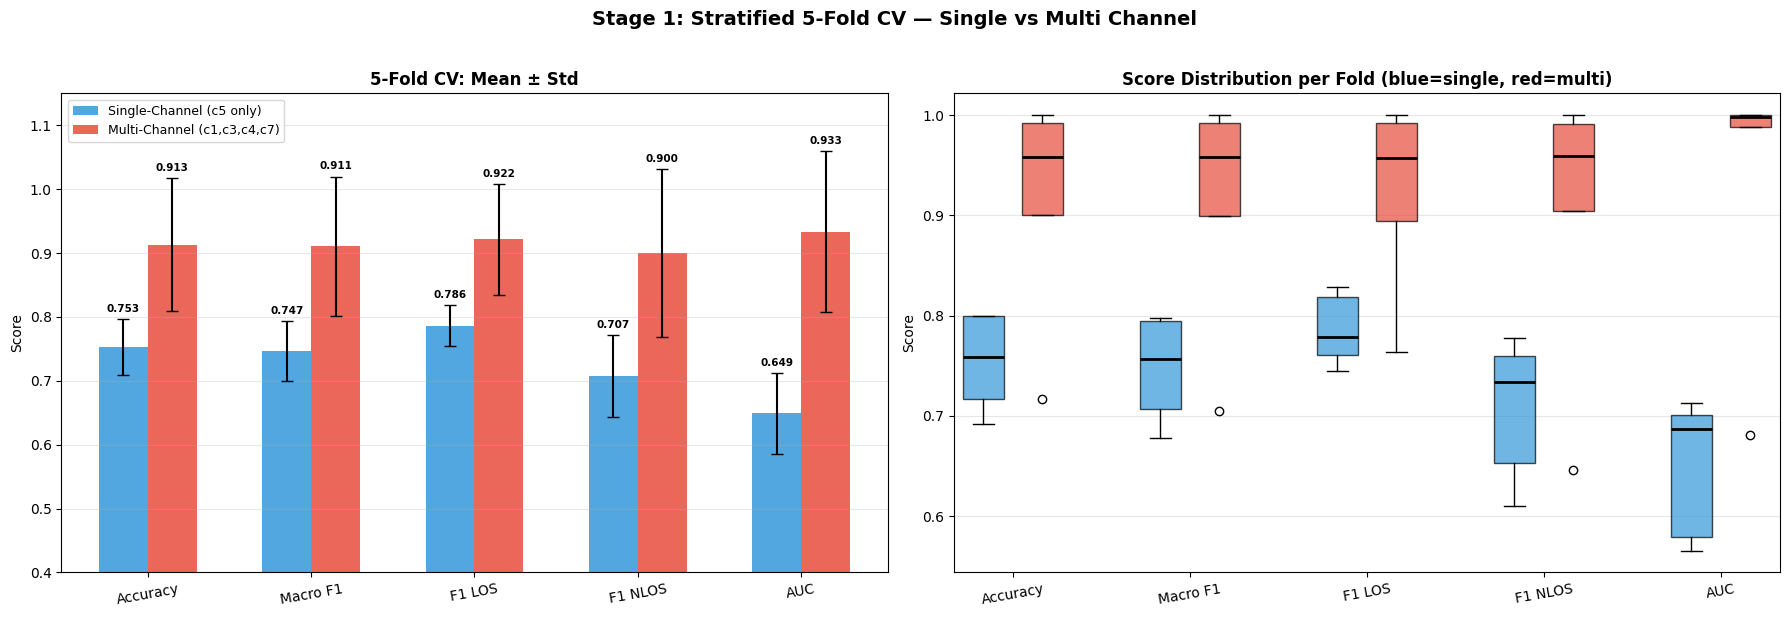


Metric            Single Mean±Std       Multi Mean±Std  Delta
Accuracy       0.7533±0.0437        0.9133±0.1044   ▲0.1600
Macro F1       0.7466±0.0476        0.9109±0.1089   ▲0.1643
F1 LOS         0.7862±0.0324        0.9215±0.0871   ▲0.1354
F1 NLOS        0.7071±0.0644        0.9003±0.1316   ▲0.1932
AUC            0.6489±0.0632        0.9334±0.1264   ▲0.2845


In [20]:
# ── K-Fold comparison plots ────────────────────────────────────────────
_kf = [kfold_single, kfold_multi]
_colors = ['#3498db', '#e74c3c']
_mk = ['acc','f1_macro','f1_los','f1_nlos','auc']
_mn = ['Accuracy','Macro F1','F1 LOS','F1 NLOS','AUC']
width = 0.3

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Bar with error bars
ax = axs[0]
x = np.arange(len(_mk))
for i, (kf, c) in enumerate(zip(_kf, _colors)):
    means = [kf[m]['mean'] for m in _mk]
    stds  = [kf[m]['std']  for m in _mk]
    bars = ax.bar(x+i*width, means, width, yerr=stds, label=kf['label'],
                  color=c, alpha=0.85, capsize=4, error_kw={'elinewidth':1.5})
    for bar, m, s in zip(bars, means, stds):
        ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+s+0.008,
                f'{m:.3f}', ha='center', va='bottom', fontsize=7.5, fontweight='bold')
ax.set_xticks(x+width/2); ax.set_xticklabels(_mn, rotation=10)
ax.set_ylim([0.4,1.15]); ax.set_title('5-Fold CV: Mean ± Std', fontweight='bold')
ax.set_ylabel('Score'); ax.legend(fontsize=9); ax.grid(True, alpha=0.3, axis='y')

# Box plots
ax = axs[1]
all_data, all_colors, positions = [], [], []
for mi, metric in enumerate(_mk):
    for ki, (kf, c) in enumerate(zip(_kf, _colors)):
        positions.append(mi*3 + ki)
        all_data.append(kf[metric]['all'])
        all_colors.append(c)
bp = ax.boxplot(all_data, positions=positions, widths=0.7, patch_artist=True,
                medianprops={'color':'black','linewidth':2})
for patch, c in zip(bp['boxes'], all_colors):
    patch.set_facecolor(c); patch.set_alpha(0.7)
ax.set_xticks([mi*3+0.5 for mi in range(len(_mk))])
ax.set_xticklabels(_mn, rotation=10)
ax.set_title('Score Distribution per Fold (blue=single, red=multi)', fontweight='bold')
ax.set_ylabel('Score'); ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Stage 1: Stratified 5-Fold CV — Single vs Multi Channel',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout(); plt.show()

print('\n' + '='*65)
print(f"{'Metric':<12} {'Single Mean±Std':>20} {'Multi Mean±Std':>20}  Delta")
print('='*65)
for k, n in zip(_mk, _mn):
    sm,ss = kfold_single[k]['mean'], kfold_single[k]['std']
    mm,ms = kfold_multi[k]['mean'],  kfold_multi[k]['std']
    d = mm - sm
    print(f"{n:<12} {sm:>8.4f}±{ss:.4f}      {mm:>8.4f}±{ms:.4f}   {'▲' if d>0 else '▼'}{abs(d):.4f}")
print('='*65)